In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imsave
from scipy import stats

In [2]:
import os, shutil

In [3]:
from collections import OrderedDict
CATEGORY_DICT = OrderedDict({
0 : "airplane", 
1: "automobile",
2: "bird",
3:"cat",
4:"deer",
5:"dog",
6:"frog",
7:"horse",
8:"ship",
9:"truck"
})

In [4]:
MODE = "generated" # "train" or "test" or "generated"
MAX_LOAD = 300 # Don't cross over 500
CLEAR_EXISTING = True

In [5]:
BASE_DIR = os.getcwd()
STATS_DIR = os.path.join(BASE_DIR, "stats")
IMAGES_DIR = os.path.join(BASE_DIR, "images")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
assert(os.path.exists(STATS_DIR))

In [6]:
TRAIN_IMAGES_DIR = os.path.join(IMAGES_DIR, "train")
TEST_IMAGES_DIR = os.path.join(IMAGES_DIR, "test")
GENERATED_IMAGES_DIR = os.path.join(IMAGES_DIR, "generated")
if not os.path.exists(IMAGES_DIR):
    os.mkdir(IMAGES_DIR)
    os.mkdir(TRAIN_IMAGES_DIR)
    os.mkdir(TEST_IMAGES_DIR)
    os.mkdir(GENERATED_IMAGES_DIR)
else:
    if not os.path.exists(TRAIN_IMAGES_DIR):
        os.mkdir(TRAIN_IMAGES_DIR)
    if not os.path.exists(TEST_IMAGES_DIR):
        os.mkdir(TEST_IMAGES_DIR)
    if not os.path.exists(GENERATED_IMAGES_DIR):
        os.mkdir(GENERATED_IMAGES_DIR)

In [7]:
if MODE == "train":
    IMAGES_SOURCE_DIR = TRAIN_IMAGES_DIR
elif MODE == "test":
    IMAGES_SOURCE_DIR = TEST_IMAGES_DIR
elif MODE == "generated":
    IMAGES_SOURCE_DIR = GENERATED_IMAGES_DIR

In [8]:
if CLEAR_EXISTING:
    shutil.rmtree(IMAGES_SOURCE_DIR)
    os.mkdir(IMAGES_SOURCE_DIR)

In [9]:
if not os.path.exists(PLOTS_DIR):
    os.mkdir(PLOTS_DIR)

In [10]:
fname = os.path.join(STATS_DIR, MODE+"_outputs.pkl")
with open(fname, "rb") as f:
    d = pickle.load(f)
X = np.array(d["images"])
y = np.array(d["labels"]) if d["labels"] is not None else None
d_out = np.array(d["critic_outputs"])

In [11]:
perm = np.random.permutation(len(X))
X = X[perm]
y = y[perm] if y is not None else None
d_out = d_out[perm]

In [12]:
for i in range(MAX_LOAD):
    imsave(os.path.join(IMAGES_SOURCE_DIR, str(i)+".png"), X[i])

/home/sudeep/.conda/envs/keras_gpu_tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


In [13]:
kde = stats.gaussian_kde(d_out)

est = kde(d_out).tolist()

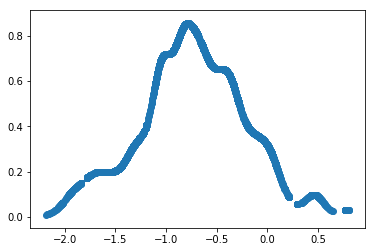

In [15]:
plt.scatter(d_out, est)
plt.savefig(os.path.join(PLOTS_DIR, MODE+"_density_estimate.png"))
plt.show()

In [16]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource, reset_output, output_notebook
from bokeh.transform import linear_cmap
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
reset_output()

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="48" width="48"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""


if MODE != "generated":
    source = ColumnDataSource(data=dict(
        x=d_out[:MAX_LOAD],
        y=est[:MAX_LOAD],
        imgs=[os.path.join(IMAGES_SOURCE_DIR, str(i)+".png") for i in range(MAX_LOAD)],
        labels = [CATEGORY_DICT[i] for i in y[:MAX_LOAD]]
    ))
    color_map = CategoricalColorMapper(factors=list(CATEGORY_DICT.values()),
                                   palette=d3['Category10'][10])
    color = {'field': 'labels', 'transform': color_map}
    legend = 'labels'
    p = figure(x_range=(-3, 6), y_range=(0, max(0.7, np.max(est[:MAX_LOAD]))), plot_width=1600, plot_height=800, tooltips=TOOLTIPS,
           title=MODE)
    p.circle('x', 'y', color=color, size=10, source=source, legend=legend)
else:
    source = ColumnDataSource(data=dict(
        x=d_out[:MAX_LOAD],
        y=est[:MAX_LOAD],
        imgs=[os.path.join(IMAGES_SOURCE_DIR, str(i)+".png") for i in range(MAX_LOAD)]))
    color_map = None
    color = None
    legend = None
    p = figure(x_range=(-3, 6), y_range=(0, 1.25*np.max(est[:MAX_LOAD])), plot_width=1600, plot_height=800, tooltips=TOOLTIPS,
           title=MODE)
    p.circle('x', 'y', size=10, source=source)

output_file(os.path.join(PLOTS_DIR, MODE+"_stats.html"))

show(p)

------

In [21]:
MODES = ["train", "test", "generated"]

In [18]:
D_OUTS = []
for MODE in MODES:
    fname = os.path.join(STATS_DIR, MODE+"_outputs.pkl")
    with open(fname, "rb") as f:
        d = pickle.load(f)
    d_out = np.array(d["critic_outputs"])
    D_OUTS.append(d_out)

In [19]:
ESTS = []
for d_out in D_OUTS:
    kde = stats.gaussian_kde(d_out)
    ESTS.append(kde(d_out).tolist())

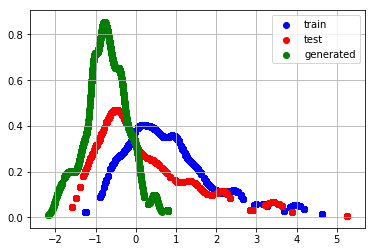

In [24]:
COLORS = ['blue', 'red', 'green']
fig, ax = plt.subplots()
for i in range(3):
    plt.scatter(D_OUTS[i], ESTS[i], label=MODES[i], color = COLORS[i])
ax.legend()
ax.grid(True)